In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score, mean_squared_error, classification_report
from sklearn import linear_model, tree, ensemble
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

## Analysing the data

In [3]:
df = pd.DataFrame(X_train)
df.columns = col_names
df

,D00,D01,D02,D03,D04,D05,D06,D07,D08,D09,...,FP2079,FP2080,FP2081,FP2082,FP2083,FP2084,FP2085,FP2086,FP2087,FP2088
0,541.280138,541.656,10.0,1.0,8.0,1.0,10.0,40.0,75.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,426.197714,426.582,5.0,1.0,9.0,1.0,4.0,30.0,60.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,348.183778,348.446,4.0,0.0,3.0,0.0,3.0,26.0,50.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1455.763803,1456.831,27.0,19.0,23.0,17.0,16.0,105.0,206.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,387.151368,387.886,4.0,0.0,4.0,0.0,4.0,27.0,50.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7332,467.149047,467.513,6.0,0.0,6.0,0.0,5.0,32.0,56.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7333,240.162649,240.350,2.0,0.0,3.0,0.0,2.0,18.0,38.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7334,510.317874,510.802,4.0,0.0,10.0,0.0,4.0,37.0,79.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7335,393.187483,393.556,4.0,2.0,5.0,1.0,5.0,28.0,55.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
s = df.isnull().sum() #check for missing values
s.sum()

0

The dataset contains 7337 instances with 2132 features, of which 43 features are labeled as D and the rest labeled as FP.

The D labeled features are all positive with different means. The FP features are either 0 or 1, but are not one-hot enconded.

It makes more sense to scale only the D features, as scalling the FP features would destroy their binary structure.

In [5]:
scaler = StandardScaler()
scaler.fit(df.iloc[:,:43]) #fit the scaler for the D columns
df_fp = df.iloc[:,43:].astype(int)
df_scale = pd.concat([pd.DataFrame(scaler.transform(df.iloc[:,:43])), df_fp], axis=1)
df_scale.columns = col_names
df_scale

,D00,D01,D02,D03,D04,D05,D06,D07,D08,D09,...,FP2079,FP2080,FP2081,FP2082,FP2083,FP2084,FP2085,FP2086,FP2087,FP2088
0,0.609921,0.608648,1.098414,-0.081854,0.246156,-0.058057,1.908209,0.737657,0.614996,0.773281,...,0,0,0,0,0,0,0,0,0,0
1,-0.023790,-0.024513,-0.103427,-0.081854,0.413306,-0.058057,-0.243126,-0.038629,0.032423,-0.135107,...,0,0,0,0,0,0,0,0,0,0
2,-0.453381,-0.454433,-0.343795,-0.477479,-0.589590,-0.508809,-0.601682,-0.349144,-0.355960,-0.589301,...,1,0,0,0,0,0,0,0,0,0
3,5.645607,5.644129,5.184672,7.039406,2.753396,7.153978,4.059544,5.783518,5.702803,4.861029,...,0,0,0,0,0,0,0,1,1,1
4,-0.238802,-0.237426,-0.343795,-0.477479,-0.422441,-0.508809,-0.243126,-0.271515,-0.355960,-0.135107,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7332,0.201712,0.200698,0.136941,-0.477479,-0.088142,-0.508809,0.115430,0.116628,-0.122930,0.773281,...,0,0,0,0,0,0,0,0,0,0
7333,-1.048209,-1.049199,-0.824531,-0.477479,-0.589590,-0.508809,-0.960238,-0.970173,-0.822018,-1.043495,...,0,0,0,0,0,0,0,0,1,0
7334,0.439425,0.438883,-0.343795,-0.477479,0.580455,-0.508809,-0.243126,0.504771,0.770349,-0.362204,...,0,0,0,1,0,0,0,0,0,0
7335,-0.205564,-0.206229,-0.343795,0.313772,-0.255292,-0.058057,0.115430,-0.193886,-0.161769,-0.362204,...,1,0,0,0,0,0,0,0,0,0


In [6]:
df_scale.dtypes

D00       float64
D01       float64
D02       float64
D03       float64
D04       float64
           ...   
FP2084      int32
FP2085      int32
FP2086      int32
FP2087      int32
FP2088      int32
Length: 2132, dtype: object

## Visualizing the distribution of features

### D features

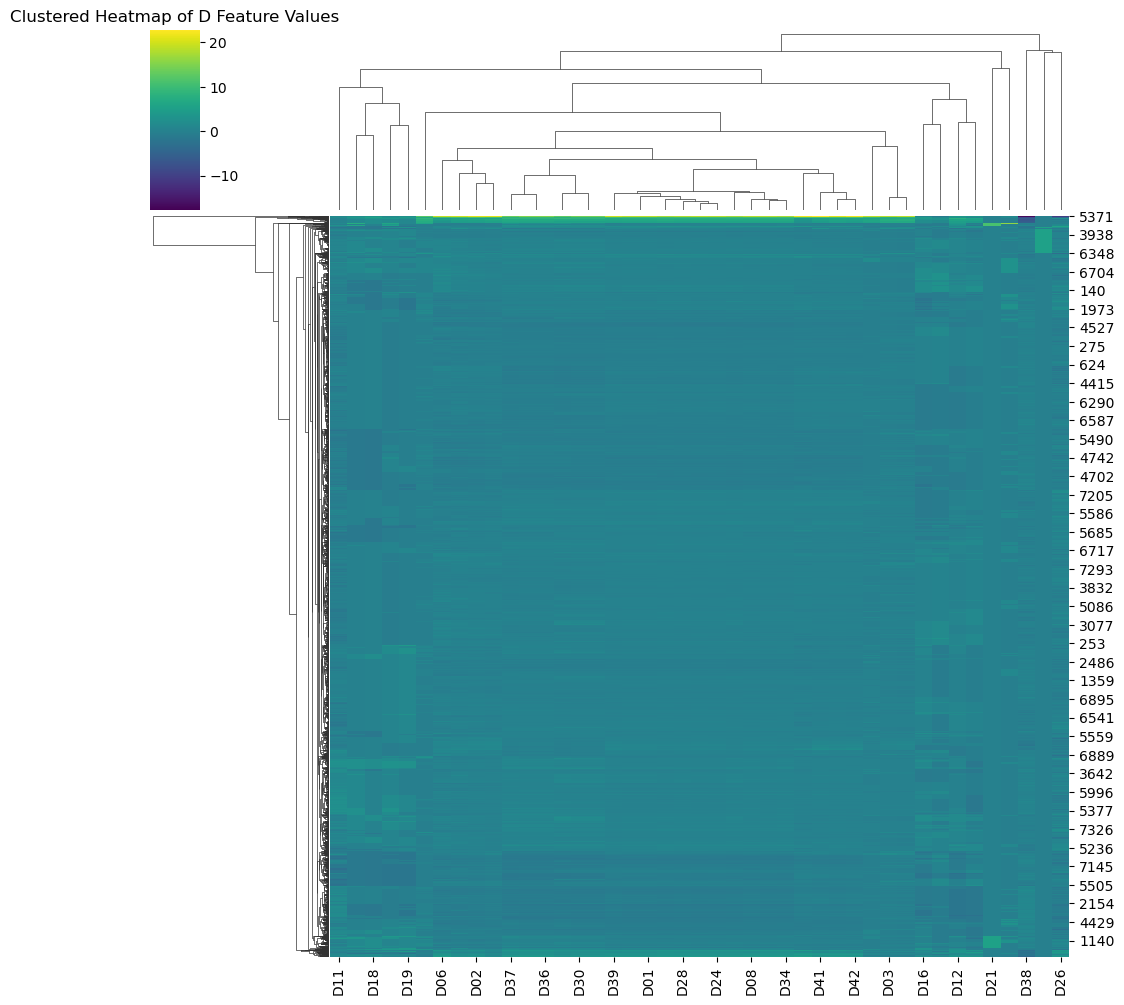

In [7]:
d_df = df_scale.iloc[:,:43]
sns.clustermap(d_df, cmap='viridis', figsize=(10, 10), method='average', metric='euclidean')
plt.title("Clustered Heatmap of D Feature Values")
plt.show()

### FP features

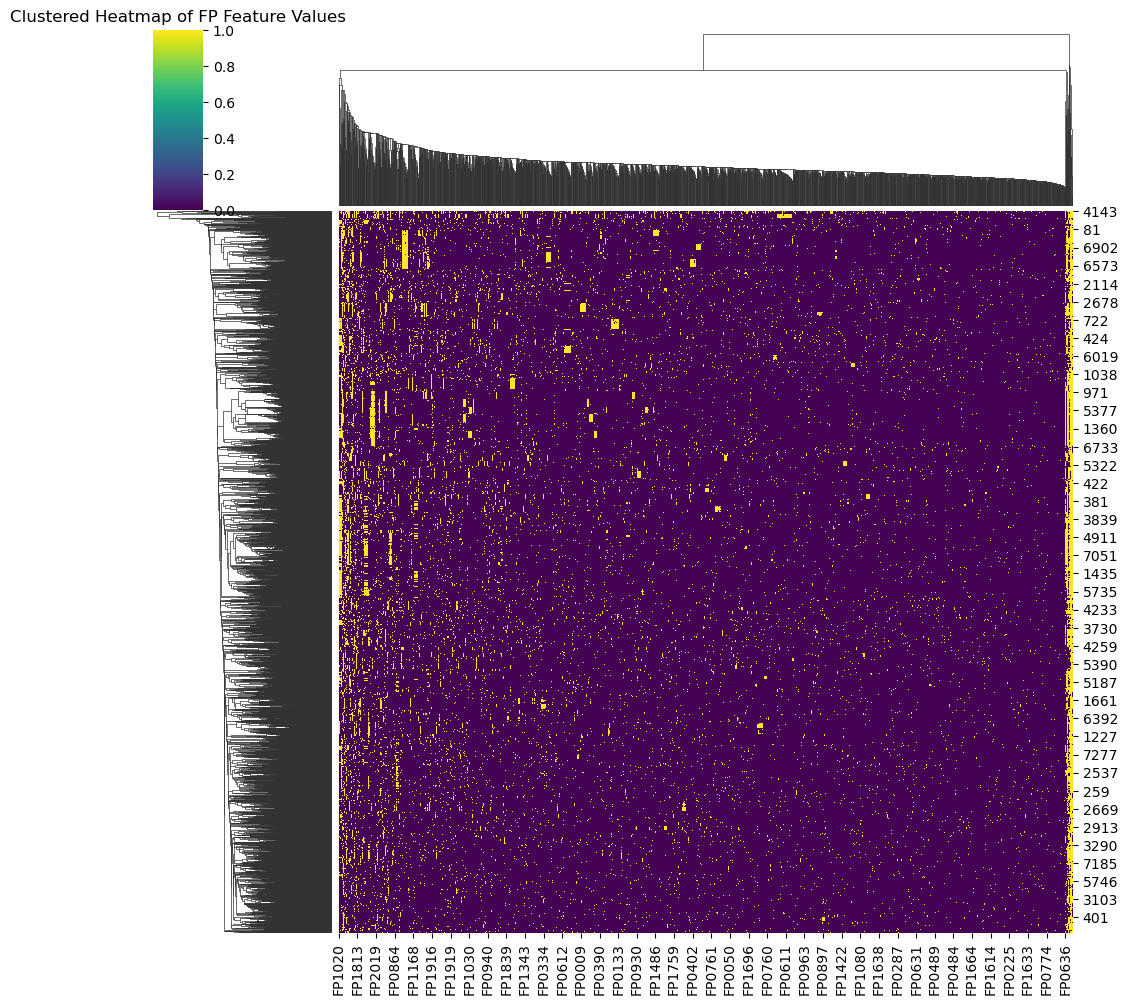

In [8]:
sns.clustermap(df_fp, cmap='viridis', figsize=(10, 10), method='average', metric='euclidean')
plt.title("Clustered Heatmap of FP Feature Values")
plt.show()

In [9]:
X_t=np.array(df_scale)

## Model Testing

We start by testing some models with the full dataset to assess the dificulty of the problem

In [10]:
D={"Model":[], 
   "RVE": [],
   "rmse": []}

def RegStats(model, y_test, pred):

    print("The RVE is: ", explained_variance_score(y_test, pred))
    print("The rmse is: ", mean_squared_error(y_test, pred, squared=False))

    D["Model"].append(model)
    D["RVE"].append(explained_variance_score(y_test, pred))
    D["rmse"].append(mean_squared_error(y_test, pred, squared=False))

In [11]:
def RegStat(y_test, pred):
    print("The RVE is: ", explained_variance_score(y_test, pred))
    print("The rmse is: ", mean_squared_error(y_test, pred, squared=False))

In [12]:
from sklearn.model_selection import train_test_split
X_TRAIN, X_test, y_TRAIN, y_test = train_test_split(X_t,y_train, test_size=0.2, random_state=1337)

In [13]:
lasso = Lasso(alpha=0.0003)
lasso.fit (X_TRAIN, y_TRAIN)
predLasso = lasso.predict(X_test)
RegStats('Lasso', y_test, predLasso)

The RVE is:  0.5808241208725338
The rmse is:  0.18026708985222933


### Random Forests

In [14]:
rf=RandomForestRegressor()
rf.fit(X_TRAIN, y_TRAIN)
pred_rf = rf.predict(X_test)
RegStat(y_test, pred_rf)

The RVE is:  0.6441585662945306
The rmse is:  0.16641846093784146


In [15]:
rf=RandomForestRegressor(n_estimators=420)
rf.fit(X_TRAIN, y_TRAIN)
pred_rf = rf.predict(X_test)
RegStats('RForest', y_test, pred_rf)

The RVE is:  0.646027820353201
The rmse is:  0.1660005117423693


### Support Vector Regression

In [16]:
svr=SVR()
svr.fit(X_TRAIN, y_TRAIN)
pred_svr = svr.predict(X_test)
RegStat(y_test, pred_svr)

The RVE is:  0.6551312299462362
The rmse is:  0.16380517672966394


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C' : [0.7, 0.8, 0.9], 'epsilon' : [0.05, 0.01, 0.005]}

svr_model = SVR()
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(X_TRAIN, y_TRAIN)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'C': 0.7, 'epsilon': 0.01}
Best score:  0.6603386193744243


In [19]:
svr=grid_search.best_estimator_
svr.fit(X_TRAIN, y_TRAIN)
pred_svr = svr.predict(X_test)
RegStats('SVR_CV', y_test, pred_svr)

The RVE is:  0.6797335181269536
The rmse is:  0.157709796008734


In [20]:
svr=SVR(C= 0.8, epsilon= 0.01)
svr.fit(X_TRAIN, y_TRAIN)
pred_svr = svr.predict(X_test)
RegStats('SVR', y_test, pred_svr)

The RVE is:  0.6802647399801605
The rmse is:  0.1575916680375879


### XGBoost

In [21]:
import xgboost as xgb
from xgboost import XGBRegressor
bst = XGBRegressor()
bst.fit(X_TRAIN, y_TRAIN)
preds_bst = bst.predict(X_test)

RegStat(y_test, preds_bst)

The RVE is:  0.6336237073371658
The rmse is:  0.16873192628274303


In [22]:
param_grid = {'n_estimators' : [100, 200, 420, 600], 'learning_rate' : [0.1, 0.05, 0.01]}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(X_TRAIN, y_TRAIN)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'n_estimators': 600}
Best score:  0.6338783886367217


In [23]:
bst = XGBRegressor(n_estimators=600, learning_rate=0.1)
bst.fit(X_TRAIN, y_TRAIN)
preds_bst = bst.predict(X_test)

RegStats('XGB', y_test, preds_bst)

The RVE is:  0.6634469044662537
The rmse is:  0.1616999363548422


### Multi-Layer Perceptrons

In [25]:
MLP = MLPRegressor(hidden_layer_sizes = 4000)
MLP.fit(X_TRAIN,y_TRAIN)
preds_MLP= MLP.predict(X_test)
RegStats('MLP', y_test, preds_MLP)

The RVE is:  0.6462836336001969
The rmse is:  0.16600854679958646


## Evaluating the models

In [26]:
results=pd.DataFrame(D)
results = results.style.set_properties(**{'text-align': 'center'})
results

,Model,RVE,rmse
0,Lasso,0.580824,0.180267
1,RForest,0.646028,0.166001
2,SVR_CV,0.679734,0.157710
3,SVR,0.680265,0.157592
4,XGB,0.663447,0.161700
5,MLP,0.646284,0.166009


### Testing feature importance and selection

In [27]:
from sklearn.feature_selection import SelectFromModel
rf=RandomForestRegressor(random_state=0)
sel = SelectFromModel(estimator=rf, threshold='1.25*mean') #select features above the mean
sel.fit(X_TRAIN, y_TRAIN)

print("Importances: ", sel.estimator_.feature_importances_)

print("Default threshold: ", sel.threshold_)

features=sel.get_support()
Features_selected =np.arange(len(col_names))[features]
print("The features selected are columns: ", Features_selected)

Importances:  [0.00394294 0.00374952 0.00225291 ... 0.00011596 0.00045499 0.00014211]
Default threshold:  0.0005863039399624766
The features selected are columns:  [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   22   23   24   25   26   27   28   29
   30   31   32   33   34   35   36   37   38   39   40   41   42   52
   74   83   96  103  106  108  137  142  152  165  180  186  198  199
  200  216  234  246  278  287  296  303  316  335  336  347  348  353
  355  359  362  364  377  381  386  421  440  442  444  455  459  470
  472  494  513  525  533  536  546  550  551  561  564  570  608  613
  615  623  646  675  679  695  713  717  719  722  727  728  758  769
  778  790  808  811  815  819  839  851  853  862  867  871  873  879
  886  889  891  893  907  909  916  924  939  949  950  956  959  965
  966  973  981  982  987  994  997 1013 1020 1029 1037 1041 1054 1062
 1063 1073 1075 1087 1088 1090 1106 1121 1132 1135 1139

In [43]:
print ("Number of features selected:", len(Features_selected))

Number of features selected: 274


In [32]:
def model_testing(X_train, X_test, y_train, y_test):

    rfr= RandomForestRegressor()
    rfr.fit(X_train, y_train)

    bst = XGBRegressor(n_estimators=600, learning_rate=0.1)
    bst.fit(X_train, y_train)

    
    knn = KNeighborsRegressor(n_neighbors=50)
    knn.fit(X_train, y_train)
    
    svr=SVR(C= 0.8, epsilon= 0.01)
    svr.fit(X_train, y_train)
    
    preds_bst = bst.predict(X_test)
    pred_svr = svr.predict(X_test)
    rf_preds=rfr.predict(X_test)
    knn_preds=knn.predict(X_test)

    print("RVE RFs: %7.4f" % explained_variance_score(y_test, rf_preds))
    print("RVE XGB: %7.4f" % explained_variance_score(y_test, preds_bst))
    print("RVE SVR: %7.4f" % explained_variance_score(y_test, pred_svr))
    print("RVE KNN: %7.4f" % explained_variance_score(y_test, knn_preds))

In [33]:
nX_train=sel.transform(X_TRAIN)
nX_test=sel.transform(X_test)
model_testing(nX_train, nX_test, y_TRAIN, y_test)

RVE RFs:  0.6353
RVE XGB:  0.6351
RVE SVR:  0.6588
RVE KNN:  0.4706


Reducing the dimensionality of the dataset from 2132 to 274 yields similar performance in RFs, XGB and SVR

### Testing Kernel PCA

In [54]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=40, kernel='poly', gamma=3)
kpca.fit(nX_train)
print("Eigenvalues:", kpca.eigenvalues_)

Eigenvalues: [9.89186990e+13 1.21660128e+12 3.03472306e+11 2.05727328e+11
 1.56827413e+11 1.20919307e+11 3.49825539e+10 3.40053265e+10
 2.17346594e+10 1.75052379e+10 1.68762021e+10 1.30103699e+10
 1.07540055e+10 8.38987905e+09 7.41514032e+09 5.91076362e+09
 4.54892846e+09 4.35788335e+09 4.09669987e+09 3.83111781e+09
 3.33902489e+09 2.38822859e+09 2.25970864e+09 2.20588974e+09
 1.96279398e+09 1.83474788e+09 1.45005989e+09 1.40607984e+09
 1.19528517e+09 1.11376298e+09 1.07262750e+09 1.02485775e+09
 9.93841170e+08 8.80748228e+08 7.99250502e+08 6.98374133e+08
 6.74763374e+08 6.49431497e+08 5.78279043e+08 5.50119589e+08]


In [55]:
pX_train=kpca.transform(nX_train)
pX_test=kpca.transform(nX_test)
model_testing(pX_train, pX_test, y_TRAIN, y_test)

RVE RFs:  0.4488
RVE XGB:  0.4580
RVE SVR:  0.0145
RVE KNN:  0.2273


Kernel PCA does not seem to produce good results for this problem. 

### Testing PCA

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 80)
pca.fit(nX_train)
tve=0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()
print("Actual Eigenvalues:", pca.singular_values_)
for i,comp in enumerate(pca.components_):
    print("PC",i, "-->", comp)

PC0 - Variance explained:  0.4364 - Total Variance:  0.4364
PC1 - Variance explained:  0.0686 - Total Variance:  0.5049
PC2 - Variance explained:  0.0527 - Total Variance:  0.5576
PC3 - Variance explained:  0.0380 - Total Variance:  0.5956
PC4 - Variance explained:  0.0339 - Total Variance:  0.6295
PC5 - Variance explained:  0.0233 - Total Variance:  0.6528
PC6 - Variance explained:  0.0201 - Total Variance:  0.6730
PC7 - Variance explained:  0.0175 - Total Variance:  0.6904
PC8 - Variance explained:  0.0150 - Total Variance:  0.7054
PC9 - Variance explained:  0.0130 - Total Variance:  0.7185
PC10 - Variance explained:  0.0117 - Total Variance:  0.7302
PC11 - Variance explained:  0.0107 - Total Variance:  0.7409
PC12 - Variance explained:  0.0091 - Total Variance:  0.7500
PC13 - Variance explained:  0.0087 - Total Variance:  0.7587
PC14 - Variance explained:  0.0080 - Total Variance:  0.7667
PC15 - Variance explained:  0.0071 - Total Variance:  0.7739
PC16 - Variance explained:  0.0070

In [61]:
pX_train=pca.transform(nX_train)
pX_test=pca.transform(nX_test)
model_testing(pX_train, pX_test, y_TRAIN, y_test)

RVE RFs:  0.5377
RVE XGB:  0.5887
RVE SVR:  0.6331
RVE KNN:  0.4643


Using 80 Principal Components we can still maintain most of the performance from Support Vector Regression.

This will be our chosen model for the problem

## Building the full model

Select the features from the full dataset with random forest regressor as an estimator

In [65]:
rf=RandomForestRegressor(random_state=0)
sel = SelectFromModel(estimator=rf, threshold='1.25*mean') #select features above the mean
sel.fit(X_t, y_train)

print("Importances: ", sel.estimator_.feature_importances_)

print("Default threshold: ", sel.threshold_)

features=sel.get_support()
Features_selected =np.arange(len(col_names))[features]
print("The features selected are columns: ", Features_selected)

Importances:  [3.40965876e-03 4.28307135e-03 2.42139274e-03 ... 8.64123118e-05
 4.11443839e-04 7.77656778e-05]
Default threshold:  0.0005863039399624766
The features selected are columns:  [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   22   23   24   25   26   27   28   29
   30   31   32   33   34   35   36   37   38   39   40   41   42   62
   67   74   96  103  122  142  152  154  157  172  186  198  199  200
  214  216  232  246  278  287  303  316  335  336  347  348  351  352
  353  357  359  362  364  377  386  390  421  440  442  444  451  459
  472  494  502  513  525  536  538  546  551  558  561  570  608  613
  615  620  623  630  646  675  676  679  695  717  722  727  728  758
  769  778  790  808  815  819  824  839  850  851  853  862  871  873
  876  879  886  889  891  907  909  924  939  945  950  956  959  965
  966  973  981  982  984 1013 1020 1023 1027 1029 1033 1037 1041 1054
 1062 1063 1074 1075 1087 1088

In [66]:
print ("Number of features selected:", len(Features_selected))

Number of features selected: 269


Transform the dataset with the selection criteria and apply PCA

In [67]:
nX_t=sel.transform(X_t) #select the variables
pca = PCA(n_components = 80)
pca.fit(nX_t)
tve=0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()
print("Actual Eigenvalues:", pca.singular_values_)
for i,comp in enumerate(pca.components_):
    print("PC",i, "-->", comp)

PC0 - Variance explained:  0.4529 - Total Variance:  0.4529
PC1 - Variance explained:  0.0679 - Total Variance:  0.5208
PC2 - Variance explained:  0.0532 - Total Variance:  0.5741
PC3 - Variance explained:  0.0381 - Total Variance:  0.6122
PC4 - Variance explained:  0.0333 - Total Variance:  0.6455
PC5 - Variance explained:  0.0230 - Total Variance:  0.6685
PC6 - Variance explained:  0.0195 - Total Variance:  0.6880
PC7 - Variance explained:  0.0168 - Total Variance:  0.7048
PC8 - Variance explained:  0.0146 - Total Variance:  0.7193
PC9 - Variance explained:  0.0122 - Total Variance:  0.7315
PC10 - Variance explained:  0.0111 - Total Variance:  0.7426
PC11 - Variance explained:  0.0104 - Total Variance:  0.7530
PC12 - Variance explained:  0.0086 - Total Variance:  0.7616
PC13 - Variance explained:  0.0081 - Total Variance:  0.7697
PC14 - Variance explained:  0.0071 - Total Variance:  0.7768
PC15 - Variance explained:  0.0069 - Total Variance:  0.7837
PC16 - Variance explained:  0.0067

In [69]:
pX_t=pca.transform(nX_t) #perform PCA to selected variables

Train the model

In [70]:
svr=SVR(C= 0.8, epsilon= 0.01)
svr.fit(pX_t, y_train)

SVR(C=0.8, epsilon=0.01)

## Prediction Pipeline

Import the data from the IVS and scale it

In [64]:
df_ivs = pd.DataFrame(X_ivs)
df_ivs_fp = df_ivs.iloc[:,43:].astype(int) #cast FP to int
df_ivs_scale = pd.concat([pd.DataFrame(scaler.transform(df_ivs.iloc[:,:43])), df_ivs_fp], axis=1)
df_ivs_scale.columns = col_names
df_ivs_scale

,D00,D01,D02,D03,D04,D05,D06,D07,D08,D09,...,FP2079,FP2080,FP2081,FP2082,FP2083,FP2084,FP2085,FP2086,FP2087,FP2088
0,-0.513907,-0.512487,-0.343795,-0.081854,0.079007,-0.058057,-0.601682,-0.582030,-0.317121,-0.362204,...,1,0,0,0,0,0,0,0,0,0
1,-0.403863,-0.404512,-0.584163,-0.081854,-0.255292,-0.058057,-0.243126,-0.426772,-0.278283,-0.589301,...,0,0,0,0,0,0,0,0,0,0
2,0.774827,0.776548,0.377310,-0.081854,0.079007,-0.058057,0.473986,0.660028,0.692672,0.546184,...,1,0,0,0,0,0,0,0,0,0
3,0.307205,0.306687,-0.584163,-0.081854,0.580455,-0.058057,-0.960238,0.349514,0.692672,-0.589301,...,1,0,0,1,0,0,0,0,0,0
4,0.180226,0.179047,0.377310,0.313772,0.413306,0.392696,0.115430,0.271885,0.304290,0.091990,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,0.290012,0.294004,-0.343795,-0.477479,0.246156,-0.508809,-0.601682,0.194257,0.187775,-0.135107,...,0,0,0,0,0,0,0,0,0,0
812,-0.051047,-0.052227,0.377310,-0.081854,0.413306,-0.058057,0.473986,0.038999,0.110099,0.091990,...,1,0,0,0,0,0,0,0,0,0
813,0.813298,0.812824,0.858046,-0.477479,0.079007,-0.508809,1.549653,0.737657,0.576158,1.000379,...,0,0,0,0,0,0,0,0,0,0
814,-0.657098,-0.658130,-0.584163,-0.477479,-0.756740,-0.508809,-0.601682,-0.582030,-0.433636,-0.816398,...,0,0,0,0,0,0,0,0,0,0


Apply the transformations to the IVS data

In [71]:
X_ivs_s = np.array(df_ivs_scale)
nX_ivs = sel.transform(X_ivs_s) #select the features
pX_ivs = pca.transform(nX_ivs) #perform PCA

In [86]:
preds_ivs = svr.predict(pX_ivs)
preds_ivs = np.clip(preds_ivs, 0, 1)
preds_ivs

array([0.21807027, 0.57752767, 0.32493883, 0.30370237, 0.19676012,
       0.        , 0.48841614, 0.6682462 , 0.291411  , 0.73758284,
       0.52278547, 0.31115487, 0.53422843, 0.07330893, 0.30912737,
       0.07932077, 0.28357587, 0.31154026, 0.35742435, 0.        ,
       0.94849844, 0.15354145, 0.41515186, 0.13166153, 0.26512948,
       0.29803453, 0.17073472, 0.17401842, 0.38444167, 0.15410365,
       0.04750856, 0.37768808, 0.16755315, 0.47840128, 0.75472543,
       0.26496225, 0.24486106, 0.61198302, 0.30019735, 0.40737013,
       0.31150475, 0.        , 0.24514992, 0.37296208, 0.44085816,
       0.3930793 , 0.81541166, 0.        , 0.40841767, 0.11149305,
       0.05645922, 0.18064431, 0.08701463, 0.30873342, 0.3034059 ,
       0.79203107, 0.47046764, 0.16984573, 0.51652024, 0.5672288 ,
       0.4018232 , 0.57467682, 0.53319912, 0.39714433, 0.5786009 ,
       0.46931456, 0.52446241, 0.28892826, 0.51990077, 0.26727637,
       0.3822578 , 0.09410655, 0.48553354, 0.493499  , 0.41730

In [94]:
np.savetxt("34.txt", preds_ivs, fmt='%f') #export our predictions to txt for submission